## Predictions on aggregated data

**Research question:** Predicting student reflection responses to the "How do you feel about your learning progress" question from their session interactions (response time, response correctness) and from the characteristics of the session (number of questions, feedback mode, time of the day, etc.)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_DIR = '../data/processed' # Change accordingly

from modules.models import aggregated

# Machine Learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score

In [ ]:
# Run this cell if working on Colab
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/Classtime'

## Building our dataframe
We have generated a dataset of all participant answers with session information and question information such that these participants have answered the relevant feeling of learning question. Their features have been aggregated into one row per participant with which we will perform predictions.

In [3]:
# Load preprocessed dataset
df = pd.read_csv('{}/participants_aggregated.csv.gz'.format(DATA_DIR))
df.drop(labels=['participant_id'], axis='columns', inplace=True)
df.head()

,min_answer_time,max_answer_time,mean_answer_time,std_answer_time,mode,feedback_mode,force_reflection,timer,is_solo,title_lang,title_len,title_topic,mean_video,mean_image,mean_correctness,std_correctness,n_answers,response
0,0.0,0.000019,6.876232e-06,7.179509e-06,0.0,0.0,0.0,0.041667,0.0,0.914894,0.164062,1.00,0.0,0.333333,1.000000,0.000000,12,happy
1,0.0,0.000643,5.444873e-05,1.854787e-04,0.0,0.0,0.0,0.024369,0.0,0.159574,0.109375,1.00,0.0,0.000000,0.833333,0.389249,12,happy
2,0.0,0.000001,6.062629e-07,5.107490e-07,0.0,1.0,0.0,0.024369,0.0,0.042553,0.085938,1.00,0.0,0.000000,0.861667,0.220945,6,neutral
3,0.0,0.000027,6.914540e-06,8.718291e-06,0.0,0.0,0.0,0.024369,0.0,0.914894,0.265625,1.00,0.0,0.272727,0.788182,0.401916,11,upset
4,0.0,0.000011,3.607664e-06,3.019396e-06,0.0,0.0,0.0,0.062500,0.0,0.702128,0.320312,0.75,0.0,0.200000,0.795333,0.327804,15,neutral


## Model training and prediction

In [4]:
# Target label
y = df.pop('response')
# Features
X = df.to_numpy()

To compare models, we will use accuracy (regular and balanced) as an evaluation metric. We also compare our model performances to a baseline which simply predicts the most frequent class ("happy” in our case), which gives an accuracy of about 0.5604 and a balanced accuracy of 0.3333...

#### Baseline

In [5]:
y.value_counts()

happy      453498
neutral    243852
upset      111874
Name: response, dtype: int64

In [6]:
print(f"Baseline accuracy = {y.value_counts()[0]/len(y):.4f}")

Baseline accuracy = 0.5604


In [8]:
pred = ['happy'] * len(y)
print(f"Baseline balanced accuracy = {balanced_accuracy_score(y, pred):.4f}")

Baseline balanced accuracy = 0.3333


#### Classification
We first evaluate classification models on the prediction task

In [9]:
models = {
    'LR': LogisticRegression(random_state=123, n_jobs=-1),
    'SVM': LinearSVC(random_state=123, dual=False),
    'RF': RandomForestClassifier(random_state=123, n_jobs=-1)
}

scalers = {
    StandardScaler()
}

param_grid = {
    'LR': {
        'model__multi_class': ['ovr', 'multinomial'],
        'model__C': np.logspace(-4, 4, 20)
    },
    'SVM': {
        'model__penalty': ['l1', 'l2'],
        'model__C': np.logspace(-4, 4, 20)
    },
    'RF': {
        'model__n_estimators': [int(x) for x in np.linspace(start = 50, stop = 150, num = 5)],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
}

In [16]:
results_list = []
for scaler in scalers:
    for name in models.keys():
        print(scaler, name)
        model = models[name]
        params = param_grid[name]
        
        steps = [('scaler', scaler),
                 ('model', model)]
        pipeline = Pipeline(steps)
        scoring = {"Accuracy": 'accuracy', "Balanced": 'balanced_accuracy'}
        # Number of folds can be tuned
        search = GridSearchCV(pipeline, params, cv=5, scoring=scoring,
                              refit="Balanced", verbose=1)
        search.fit(X, y)
        results = (model, name, scaler, search.best_score_, search.best_params_, search.cv_results_)
        results_list.append(results)
results_df = pd.DataFrame(results_list, columns=['model', 'name', 'scaler', 'score', 'params', 'results']).sort_values('score', ascending=False)

StandardScaler() LR
Fitting 5 folds for each of 40 candidates, totalling 200 fits
StandardScaler() SVM
Fitting 5 folds for each of 40 candidates, totalling 200 fits
StandardScaler() RF
Fitting 5 folds for each of 45 candidates, totalling 225 fits


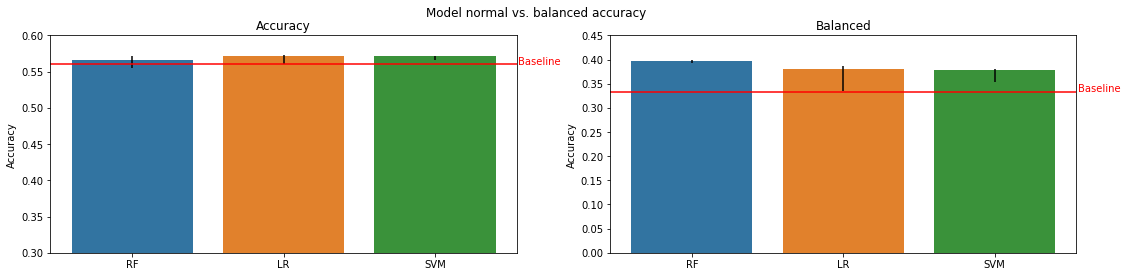

In [79]:
# Extract cross validation results
cv_results = pd.json_normalize(results_df.results).set_index(results_df.name)
cv_results['max_Balanced'] = cv_results.mean_test_Balanced.apply(lambda a: np.max(a))
cv_results['min_Balanced'] = cv_results.mean_test_Balanced.apply(lambda a: np.min(a))
cv_results['max_Accuracy'] = cv_results.mean_test_Accuracy.apply(lambda a: np.max(a))
cv_results['min_Accuracy'] = cv_results.mean_test_Accuracy.apply(lambda a: np.min(a))

# Barplot with min-max error bars
def min_max_bar(ax, title, cv_results, y_lim, baseline):
    sns.barplot(data=cv_results[f'mean_test_{title}'], ax=ax, ci=None)
    ax.set_title(title)
    ax.set_ylim(y_lim[0], y_lim[1])
    ax.axhline(baseline, color='red')
    ax.text(2.55, baseline, 'Baseline', color='red')
    ax.vlines([0, 1, 2], cv_results[f'min_{title}'], cv_results[f'max_{title}'], color='k')
    ax.set_xticklabels(cv_results.index)
    ax.set_ylabel('Accuracy')

fig, axs = plt.subplots(1, 2)
fig.suptitle('Model normal vs. balanced accuracy', x=1.25)
min_max_bar(axs[0], 'Accuracy', cv_results, (0.3, 0.6), 0.5604)
min_max_bar(axs[1], 'Balanced', cv_results, (0., 0.45), 0.3333)

# Adjust spacing between subplots
plt.subplots_adjust(right=2.5)
plt.show()

Random forests seem to have the best improvement of our considered models, which all improve upon the baseline in terms of normal and balanced accuracy. Random forests, however, seem to best perform in terms of balanced classification. That is, they perform better for all classes. In terms of normal accuracy, performance gains are only marginal (**note the small range of the y-axis**) compared to the computational cost.

In [19]:
print('Best scores (balanced accuracy):')
display(results_df[['name', 'score']])

Best scores (balanced accuracy):


,name,score
2,RF,0.398847
0,LR,0.387042
1,SVM,0.379540


We select the best model and best parameters and evaluate on a 90-10 train test split. We compare performance to a balanced dataset.

In [38]:
# Balanced dataset
X_bal = pd.read_csv(f'{DATA_DIR}/balanced_multi_agg.csv.gz').drop(labels=['participant_id'], axis='columns')
y_bal = X_bal.pop('response')

In [47]:
# Use the best parameters
best_params = { k.replace('model__', ''):v for k, v in dict(results_df.iloc[0].params).items()}
# Random Forest was best
model = RandomForestClassifier(random_state=123, n_jobs=-1, **best_params)

# Evaluate and compare
aggregated.eval_multi_model(model, X, y, 'Full')
aggregated.eval_multi_model(model, X_bal, y_bal, 'Balanced')

Dataset: Full
Accuracy: 0.5691
Balanced accuracy: 0.4092

Dataset: Balanced
Accuracy: 0.4539
Balanced accuracy: 0.4539



Although overall accuracy for the balanced dataset is around 0.1 lower compared to the full dataset, balanced accuracy actually increases by about 0.05. This means that the model performs slightly better for all outcome labels given a balanced dataset as train input.

#### Binary classification
Unfortunately, the multi-classification problem did not yield great predicting accuracy. Instead of predicting responses for each class, we will instead investigate predicting whether the student was happy or not (and turn the problem into a binary prediction problem).

In [48]:
y_bin = y.map({'happy': 'happy', 'neutral': 'not_happy', 'upset': 'not_happy'})

In [59]:
print(f"Baseline accuracy = {y_bin.value_counts()[0]/len(y_bin):.4f}")
pred = ['happy'] * len(y_bin)
print(f"Baseline balanced accuracy = {balanced_accuracy_score(y_bin, pred):.4f}")
# What was the baseline ROC AUC ?
roc = roc_auc_score(y_bin.map({'happy': 1, 'not_happy': 0}).values, [1 for _ in range(len(y_bin))])
print(f'Baseline ROC AUC = {roc:.4f}')

Baseline accuracy = 0.5604
Baseline balanced accuracy = 0.5000
Baseline ROC AUC = 0.5000


In [50]:
bin_results_list = []
for name in ['LR', 'RF']:
    print(name)
    model = models[name]
    params = param_grid[name]

    steps = [('model', model)]
    pipeline = Pipeline(steps)
    scoring = {"Accuracy": 'accuracy', "Balanced": 'balanced_accuracy', "AUC": 'roc_auc'}
    search = GridSearchCV(pipeline, params, cv=5, scoring=scoring, refit="AUC", verbose=1)
    search.fit(X, y_bin)
    results = (model, name, scaler, search.best_score_, search.best_params_, search.cv_results_)
    bin_results_list.append(results)

LR
Fitting 5 folds for each of 40 candidates, totalling 200 fits
RF
Fitting 5 folds for each of 45 candidates, totalling 225 fits


In [120]:
# Barplot with min-max error bars
def min_max_bar(ax, title, cv_results, y_lim, baseline):
    sns.barplot(data=cv_results[f'mean_test_{title}'], ax=ax, ci=None)
    ax.set_title(title)
    ax.set_ylim(y_lim[0], y_lim[1])
    ax.axhline(baseline, color='red')
    ax.text(1.45, baseline, 'Baseline', color='red')
    ax.vlines([0, 1], cv_results[f'min_{title}'], cv_results[f'max_{title}'], color='k')
    ax.set_xticklabels(cv_results.index)
    ax.set_ylabel('Accuracy')

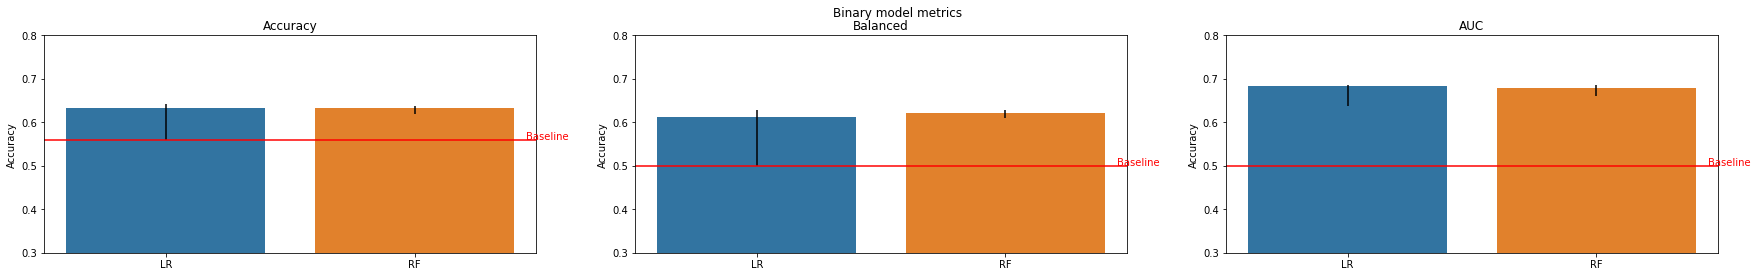

In [121]:
bin_results_df = pd.DataFrame(bin_results_list, columns=['model', 'name', 'scaler', 'score', 'params', 'results']).sort_values('score', ascending=False)
# Extract cross validation results
bin_cv_results = pd.json_normalize(bin_results_df.results).set_index(bin_results_df.name)
for metric in ['Accuracy', 'Balanced', 'AUC']:
    bin_cv_results[f'max_{metric}'] = bin_cv_results[f'mean_test_{metric}'].apply(lambda a: np.max(a))
    bin_cv_results[f'min_{metric}'] = bin_cv_results[f'mean_test_{metric}'].apply(lambda a: np.min(a))

# Plot
fig, axs = plt.subplots(1, 3)
fig.suptitle('Binary model metrics', x=2.1)
min_max_bar(axs[0], 'Accuracy', bin_cv_results, (0.3, 0.8), 0.5604)
min_max_bar(axs[1], 'Balanced', bin_cv_results, (0.3, 0.8), 0.5)
min_max_bar(axs[2], 'AUC', bin_cv_results, (0.3, 0.8), 0.5)

# Adjust spacing between subplots
plt.subplots_adjust(right=4.0)
plt.show()

In [80]:
print('Best scores:')
display(bin_results_df[['name', 'score']])

Best scores:


,name,score
0,LR,0.686705
1,RF,0.686403


The binary prediction now seems to perform a lot better than the baseline, with accuracy metrics sitting around the 0.65 mark. The ROC area under curve score also sees a significant increase from the baseline 0.5 to values around 0.69. We again compare random random forest performance on a balanced dataset.

In [5]:
# Balanced dataset
X_bal = pd.read_csv(f'{DATA_DIR}/balanced_bin_agg.csv.gz').drop(labels=['participant_id'], axis='columns')
y_bal = X_bal.pop('response')

In [118]:
# Use the best parameters
best_params = { k.replace('model__', ''):v for k, v in dict(bin_results_df.iloc[0].params).items()}
# Logistic Regression model
model = LogisticRegression(random_state=123, n_jobs=-1, **best_params)

# Evaluate and compare
aggregated.eval_bin_model(model, X, y_bin, 'Full')
aggregated.eval_bin_model(model, X_bal, y_bal, 'Balanced')

Dataset: Full
Accuracy: 0.6410
Balanced accuracy: 0.6251
AUC: 0.6251

Dataset: Balanced
Accuracy: 0.6368
Balanced accuracy: 0.6368
AUC: 0.6368



In [116]:
# Use the best parameters
best_params = { k.replace('model__', ''):v for k, v in dict(bin_results_df.iloc[1].params).items()}
# Random Forest model
model = RandomForestClassifier(random_state=123, n_jobs=-1, **best_params)

# Evaluate and compare
aggregated.eval_bin_model(model, X, y_bin, 'Full')
aggregated.eval_bin_model(model, X_bal, y_bal, 'Balanced')

Dataset: Full
Accuracy: 0.6483
Balanced accuracy: 0.6367
AUC: 0.6367

Dataset: Balanced
Accuracy: 0.6432
Balanced accuracy: 0.6432
AUC: 0.6432



Once again, the balanced dataset has a slightly lowered accuracy but improved balanced accuracy score. So far, we achieve 0.64 balanced accuracy. To try to improve performance, we will add pairwise products of the features.

#### Augmenting features

In [109]:
from sklearn.preprocessing import PolynomialFeatures
X_aug = PolynomialFeatures(2).fit_transform(X_bal)

In [117]:
aggregated.eval_bin_model(model, X_aug, y_bal, 'Balanced polynomial augmented')

Dataset: Balanced polynomial augmented
Accuracy: 0.6395
Balanced accuracy: 0.6395
AUC: 0.6395



Augmenting features does not seem to be helping for this dataset when using random forests or logistic regression. We will therefore discard this method for now.

This leads us to take interest in the importance of our considered features. We will inspect feature importances for the random forest classifier on the binary prediction task trained with the balanced dataset.
### Feature importances

In [ ]:
# First train the model
forest = RandomForestClassifier(random_state=123, n_jobs=-1, **best_params)

# Specify feature names
feature_names = X_bal.columns.values

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.1, stratify=y_bal, random_state=123)

# Fit model on balanced data
forest.fit(X_train, y_train)

#### Feature importance using MDI
MDI = mean decrease in impurity

In [ ]:
# The impurity-based feature importances
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Attach feature names to importances
forest_importances = pd.Series(importances, index=feature_names)

# Plot
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

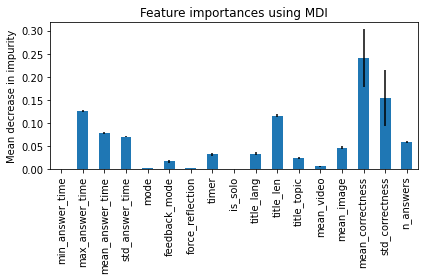

It seems like correctness was indeed a relatively important feature as hypothesized. It seems that the time to answer a question as well as title length seem to also be relatively important.

#### Feature importances using permutation on full model
Why? importances do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [ ]:
# Could not run due to RAM issues
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, X_test, y_test, n_repeats=5, random_state=123, n_jobs=-1)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()